In [ ]:
!python -m pip install pandas numpy matplotlib seaborn networkx scikit-learn

Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
df = pd.read_csv('lol_ranked_games.csv')
print(df.info())

In [ ]:
print("Total rows:", df.shape[0])
print("Total columns:", df.shape[1])
df.tail(10)

In [ ]:
print("Missing Data: \n", df.isnull().sum())

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(df.describe(include='all'))

In [ ]:
df.hist(bins=30, figsize=(20, 20))
plt.show()

In [ ]:
selected_columns = ['goldDiff', 'expDiff', 'kills', 'deaths', 'assists']
sns.pairplot(df[selected_columns])
plt.show()

In [ ]:
plt.figure(figsize=(40, 35))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
winning_correlation = df.corr()['hasWon'].to_frame().T
plt.subplots(figsize=(20, 2))
sns.heatmap(winning_correlation)
plt.show()

In [ ]:
df_f10 = df[df['frame'] == 10]
winning_correlation = df_f10.corr()['hasWon'].to_frame().T
plt.subplots(figsize=(20, 2))
sns.heatmap(winning_correlation)
plt.show()

In [ ]:
high_impact_columns = ['goldDiff', 'expDiff', 'champLevelDiff', 'kills', 'deaths', 'assists', 'isFirstTower', 'isFirstBlood']
df_high_impact = df[high_impact_columns]
print(df_high_impact.tail(10))

In [ ]:
#DATA SETUP

# Filter for frame=10
df_frame_10 = df[df['frame'] == 10].copy()

# Create derived columns
df_frame_10['kda'] = df_frame_10['kills'] + (df_frame_10['assists'] // 2) - df_frame_10['deaths']
df_frame_10['wardsDiff'] = df_frame_10['wardsPlaced'] - df_frame_10['wardsLost']

drake_columns_killed = ['killedFireDrake', 'killedWaterDrake', 'killedAirDrake', 'killedEarthDrake']
drake_columns_lost = ['lostFireDrake', 'lostWaterDrake', 'lostAirDrake', 'lostEarthDrake']
df_frame_10['drakeDiff'] = df[drake_columns_killed].sum(axis=1) - df[drake_columns_lost].sum(axis=1)

turrets_destroyed = ['destroyedTopOuterTurret', 'destroyedMidOuterTurret', 'destroyedBotOuterTurret']
turret_lost = ['lostTopOuterTurret', 'lostMidOuterTurret', 'lostBotOuterTurret']
df_frame_10['laneProgression'] = df[turrets_destroyed].sum(axis=1) - df[turret_lost].sum(axis=1)

# Discretize data
df_frame_10['goldDiff'] = (df_frame_10['goldDiff'] > 0).astype(int)
df_frame_10['expDiff'] = (df_frame_10['expDiff'] > 0).astype(int)
df_frame_10['wardsDiff'] = (df_frame_10['wardsDiff'] > 0).astype(int)
df_frame_10['drakeDiff'] = (df_frame_10['drakeDiff'] > 0).astype(int)
df_frame_10['kda'] = (df_frame_10['kda'] > 1).astype(int)
df_frame_10['killedRiftHerald'] = (df_frame_10['killedRiftHerald'] > 0).astype(int)
df_frame_10['laneProgression'] = (df_frame_10['laneProgression'] > 0).astype(int)

# Select relevant columns
df_bn = df_frame_10[['hasWon', 'goldDiff', 'expDiff', 'kda', 'wardsDiff', 'isFirstBlood', 'isFirstTower',
                     'killedRiftHerald', 'drakeDiff', 'laneProgression']]
display(df_bn.head())

# Define Bayesian network edges manually based on provided design with separate goldDiff and expDiff
edges = [
    ('kda', 'goldDiff'),
    ('kda', 'expDiff'),
    ('isFirstBlood', 'kda'),
    ('drakeDiff', 'kda'),
    ('wardsDiff', 'drakeDiff'),
    ('wardsDiff', 'isFirstBlood'),
    ('wardsDiff', 'kda'),
    ('isFirstTower', 'laneProgression'),
    ('laneProgression', 'hasWon'),
    ('killedRiftHerald', 'laneProgression'),
    ('killedRiftHerald', 'isFirstTower'),
    ('drakeDiff', 'kda'),
    ('isFirstTower', 'kda'),
    ('goldDiff', 'hasWon'),
    ('expDiff', 'hasWon')
]

# Visualize the network
plt.figure(figsize=(12, 8))
G = nx.DiGraph(edges)
nx.draw(G, with_labels=True, node_size=3000, node_color='lightblue', font_size=15, font_weight='bold')
plt.title('Bayesian Network for LoL Data with Separate goldDiff and expDiff Nodes')
plt.show()

Bayesian Network Implementation

In [ ]:
# DATA SPLITTING AND CPTS

target = 'hasWon'
train_data, test_data = train_test_split(df_bn, test_size=0.25, random_state=42)
print(f"Training Set Size: {len(train_data)}, Testing Set Size: {len(test_data)}")

# Calculating CPTs using Maximum Likelihood Estimation(MLE)
P_hasWon_given_gd_ed_lp = train_data.groupby(['goldDiff', 'expDiff', 'laneProgression'])['hasWon'].value_counts(normalize=True).unstack().fillna(0)
P_lp_given_ft_rh = train_data.groupby(['isFirstTower', 'killedRiftHerald'])['laneProgression'].value_counts(normalize=True).unstack().fillna(0)
P_gd_given_k = train_data.groupby('kda')['goldDiff'].value_counts(normalize=True).unstack().fillna(0)
P_ed_given_k = train_data.groupby('kda')['expDiff'].value_counts(normalize=True).unstack().fillna(0)
P_k_given_fb_dd_wd_ft = train_data.groupby(['isFirstBlood', 'drakeDiff', 'wardsDiff', 'isFirstTower'])['kda'].value_counts(normalize=True).unstack().fillna(0)
P_dd_given_wd = train_data.groupby('wardsDiff')['drakeDiff'].value_counts(normalize=True).unstack().fillna(0)
P_fb_given_wd = train_data.groupby('wardsDiff')['isFirstBlood'].value_counts(normalize=True).unstack().fillna(0)
P_ft_given_rh = train_data.groupby('killedRiftHerald')['isFirstTower'].value_counts(normalize=True).unstack().fillna(0)

# Compute marginal probabilities for nodes without parents
P_wd = train_data['wardsDiff'].value_counts(normalize=True).to_dict()
P_rh = train_data['killedRiftHerald'].value_counts(normalize=True).to_dict()

# DATA VISUALIZING
display(P_hasWon_given_gd_ed_lp)
display(P_lp_given_ft_rh)
display(P_ed_given_k)
display(P_k_given_fb_dd_wd_ft)
display(P_dd_given_wd)
display(P_fb_given_wd)
display(P_ft_given_rh)
display(P_wd)
display(P_rh)

In [ ]:
# DATA TRAINING

def predict_win_probability(evidence):
    """
    Computes P(hasWon | evidence) using the trained Bayesian Network.
    """
    try:
        # Extract evidence values
        gd, ed, lp = evidence['goldDiff'], evidence['expDiff'], evidence['laneProgression']

        # Compute probability of winning and losing
        P_win = P_hasWon_given_gd_ed_lp.loc[gd, ed, lp].get(1, 1e-6)  # P(hasWon=1 | gd, ed, lp)
        P_lose = P_hasWon_given_gd_ed_lp.loc[gd, ed, lp].get(0, 1e-6)  # P(hasWon=0 | gd, ed, lp)

        # Normalize probabilities
        total = P_win + P_lose
        P_win /= total
        P_lose /= total

        return 1 if P_win > P_lose else 0  # Return predicted class
    
    except KeyError as e:
        print(f"Missing key: {e}, using default probability")
        return np.random.choice([0, 1])  # Randomly assign if missing values

In [ ]:
# DATA TESTING AND EVALUATING

# Testing data
test_data['predicted_hasWon'] = test_data.apply(lambda row: predict_win_probability(row), axis=1)

# Compute accuracy
accuracy = (test_data['hasWon'] == test_data['predicted_hasWon']).mean()
print(f"Model Accuracy: {accuracy*100:.2f}{'%'}")

# Compute confusion matrix
cm = confusion_matrix(test_data['hasWon'], test_data['predicted_hasWon'])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Lose", "Win"], yticklabels=["Lose", "Win"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

HMM Model Implementation

Model Accuracy: 49.81%


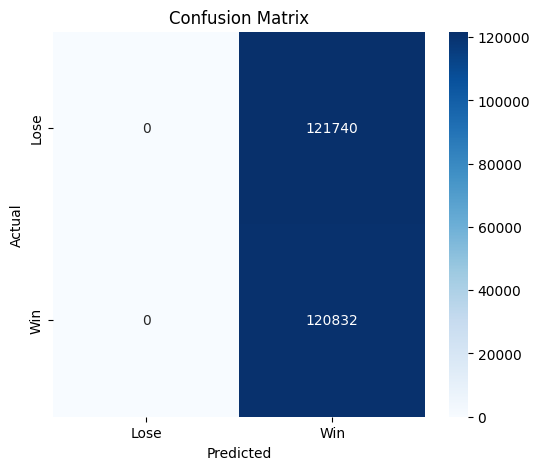

In [54]:
# Define hidden states
hidden_states = ['Disadvantaged', 'Even', 'Advantageous']
n_states = len(hidden_states)

# Create derived columns for full dataset (not just frame=10)
df['kda'] = df['kills'] + (df['assists'] // 2) - df['deaths']
df['wardsDiff'] = df['wardsPlaced'] - df['wardsLost']
drake_columns_killed = ['killedFireDrake', 'killedWaterDrake', 'killedAirDrake', 'killedEarthDrake']
drake_columns_lost = ['lostFireDrake', 'lostWaterDrake', 'lostAirDrake', 'lostEarthDrake']
df['drakeDiff'] = df[drake_columns_killed].sum(axis=1) - df[drake_columns_lost].sum(axis=1)
turrets_destroyed = ['destroyedTopOuterTurret', 'destroyedMidOuterTurret', 'destroyedBotOuterTurret']
turret_lost = ['lostTopOuterTurret', 'lostMidOuterTurret', 'lostBotOuterTurret']
df['laneProgression'] = df[turrets_destroyed].sum(axis=1) - df[turret_lost].sum(axis=1)

# Discretize relevant columns
df['goldDiff'] = (df['goldDiff'] > 0).astype(int)
df['expDiff'] = (df['expDiff'] > 0).astype(int)
df['wardsDiff'] = (df['wardsDiff'] > 0).astype(int)
df['drakeDiff'] = (df['drakeDiff'] > 0).astype(int)
df['kda'] = (df['kda'] > 1).astype(int)
df['killedRiftHerald'] = (df['killedRiftHerald'] > 0).astype(int)
df['laneProgression'] = (df['laneProgression'] > 0).astype(int)

# Assign hidden states based on game advantage metrics
states = np.full(len(df), 'Even', dtype=object)
states[(df['goldDiff'] == 1) & (df['expDiff'] == 1)] = 'Advantageous'
states[(df['goldDiff'] == 0) & (df['expDiff'] == 0)] = 'Disadvantaged'
df['hidden_state'] = states

assert set(df['hidden_state'].unique()).issubset(set(hidden_states)), "Unexpected hidden state values found!"

##############################
# 2. Compute Transition Probabilities
##############################

transition_matrix = np.zeros((n_states, n_states))
state_map = {state: i for i, state in enumerate(hidden_states)}

for prev, curr in zip(df['hidden_state'][:-1], df['hidden_state'][1:]):
    transition_matrix[state_map[prev], state_map[curr]] += 1

# Normalize transition matrix to ensure valid probabilities
transition_matrix = (transition_matrix + 1e-6) / (transition_matrix.sum(axis=1, keepdims=True) + 1e-6)
transition_matrix = np.log(transition_matrix)  # Convert to log-space to prevent underflow

##############################
# 3. Compute Emission Probabilities
##############################

observed_features = ['goldDiff', 'expDiff', 'kda', 'wardsDiff', 
                     'isFirstBlood', 'isFirstTower', 'killedRiftHerald', 
                     'drakeDiff', 'laneProgression']

df_obs = df[observed_features].copy()
emission_matrix = np.zeros((n_states, len(observed_features)))

for state in hidden_states:
    subset = df[df['hidden_state'] == state][observed_features]
    if not subset.empty:
        emission_matrix[state_map[state], :] = subset.mean().values

# Convert to log-space
emission_matrix = np.log(emission_matrix + 1e-6)

##############################
# 4. Forward-Backward Algorithm for Smoothing
##############################

def forward_backward(observations, transition_matrix, emission_matrix, start_probs):
    T = len(observations)
    alpha = np.zeros((T, n_states))
    beta = np.zeros((T, n_states))
    
    # Forward pass
    alpha[0, :] = np.log(start_probs) + np.sum(observations[0] * emission_matrix, axis=1)
    for t in range(1, T):
        for j in range(n_states):
            alpha[t, j] = np.logaddexp.reduce(alpha[t-1] + transition_matrix[:, j]) + np.sum(observations[t] * emission_matrix[j])
    
    # Backward pass
    beta[-1, :] = 0  # log(1) = 0
    for t in range(T-2, -1, -1):
        for j in range(n_states):
            beta[t, j] = np.logaddexp.reduce(beta[t+1] + transition_matrix[j, :] + np.sum(observations[t+1] * emission_matrix, axis=1))
    
    # Compute smoothed probabilities
    smoothed_probs = alpha + beta
    smoothed_probs -= np.logaddexp.reduce(smoothed_probs, axis=1, keepdims=True)  # Normalize
    
    return smoothed_probs

##############################
# 5. Model Evaluation: Predicting Probability of Win
##############################

start_probs = np.ones(n_states) / n_states
observations = df_obs.values
smoothed_probs = forward_backward(observations, transition_matrix, emission_matrix, start_probs)

df['predicted_hidden_state'] = [hidden_states[np.argmax(p)] for p in smoothed_probs]

# Predict win based on most probable state at final time step
df['predicted_hasWon'] = (df['predicted_hidden_state'] == 'Advantageous').astype(int)

# Evaluate model performance
accuracy = accuracy_score(df['hasWon'], df['predicted_hasWon'])
conf_matrix = confusion_matrix(df['hasWon'], df['predicted_hasWon'])

print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Lose", "Win"], yticklabels=["Lose", "Win"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Other models for comparison

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.auto import tqdm

###################################
#         Configuration           #
###################################
DATA_PATH = "./data/lol_ranked_games.csv"  # Adjust if needed
TARGET_COL = "hasWon"  # Target column for classification
TEST_SIZE = 0.2
RANDOM_SEED = 1337

# Set seeds for reproducibility (PyTorch, numpy, python.random)
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
# If you have other random libs, set them similarly.

###################################
#        1. Load & Split Data     #
###################################
df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)

print("\n[Label Distribution]")
print(df[TARGET_COL].value_counts())
print("\n[Unique Labels]")
print(df[TARGET_COL].unique())

# Ensure labels are 0 or 1. If not, map them.
# Example if your dataset uses "Blue" / "Red" or 1 / 2:
# df[TARGET_COL] = df[TARGET_COL].map({"Blue": 0, "Red": 1})

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print("\nData info:")
print(df.info())

# Check for missing values
missing_vals = df.isna().sum()
print("\nMissing values in each column:\n", missing_vals)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

print(f"\nTrain set size: {X_train.shape[0]} | Test set size: {X_test.shape[0]}")

# Optional: check class distribution in training set
print("\nTraining set label distribution:")
print(y_train.value_counts(normalize=True))

##################################
#    2. Scale/Normalize Inputs   #
##################################
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test_torch  = torch.tensor(X_test_scaled,  dtype=torch.float32).to(device)
y_test_torch  = torch.tensor(y_test.values,  dtype=torch.long).to(device)

##################################
#  3. Define AdvancedNN Model    #
##################################
class AdvancedNN(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=64, hidden3=32, output_dim=2, dropout_p=0.2):
        super(AdvancedNN, self).__init__()
        # Layer 1
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.dropout1 = nn.Dropout(dropout_p)

        # Layer 2
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.dropout2 = nn.Dropout(dropout_p)

        # Layer 3
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.bn3 = nn.BatchNorm1d(hidden3)
        self.dropout3 = nn.Dropout(dropout_p)

        # Output layer
        self.fc4 = nn.Linear(hidden3, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

##############################
# 4. Initialize & Train NN   #
##############################
model = AdvancedNN(input_dim=X_train_torch.shape[1], dropout_p=0.2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # smaller LR

epochs = 50
batch_size = 128

print("\n[Training Advanced Neural Network]")
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_torch.size(0))

    running_loss = 0.0
    num_batches = int(np.ceil(X_train_torch.size(0) / batch_size))

    batch_iter = tqdm(range(0, X_train_torch.size(0), batch_size),
                      desc=f"Epoch {epoch+1}/{epochs}",
                      leave=False)

    for i in batch_iter:
        indices = permutation[i : i + batch_size]
        batch_x, batch_y = X_train_torch[indices], y_train_torch[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Evaluate on test set each epoch
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_torch)
        _, test_preds = torch.max(test_outputs, 1)
        test_acc = (test_preds == y_test_torch).float().mean().item()

    avg_loss = running_loss / num_batches
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}, Test Acc: {test_acc:.4f}")

# Final NN Accuracy
model.eval()
with torch.no_grad():
    final_outputs = model(X_test_torch)
    _, final_preds = torch.max(final_outputs, 1)
nn_acc = (final_preds == y_test_torch).float().mean().item()
print(f"[Advanced Neural Network] Final Test Accuracy: {nn_acc:.4f}")

##############################
#  5. Sanity Check Overfit   #
##############################
# (Optional) Test if the network can overfit a small subset
# If it can't get near 100% on the training subset, there's definitely something wrong.
subset_size = 200  # or smaller if your data is huge
X_small = X_train_torch[:subset_size]
y_small = y_train_torch[:subset_size]

tmp_model = AdvancedNN(input_dim=X_small.shape[1], dropout_p=0.0).to(device)
tmp_optimizer = optim.Adam(tmp_model.parameters(), lr=1e-3)

for epoch in range(100):
    tmp_model.train()
    tmp_optimizer.zero_grad()
    outputs = tmp_model(X_small)
    loss = criterion(outputs, y_small)
    loss.backward()
    tmp_optimizer.step()

    with torch.no_grad():
        preds = tmp_model(X_small)
        _, pred_classes = torch.max(preds, 1)
        train_acc = (pred_classes == y_small).float().mean().item()

    if (epoch+1) % 10 == 0:
        print(f"[Overfit Check] Epoch {epoch+1}, Loss: {loss.item():.4f}, Acc: {train_acc:.4f}")

# If this "overfit check" doesn't reach 95%+ accuracy on a tiny subset,
# there's likely a data or code bug.

##############################
#    6. Save the Model       #
##############################
torch.save(model.state_dict(), "advanced_nn_checkpoint.pth")
print(f"\nFinal Test Accuracy (full) = {nn_acc:.4f}")


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1) XGBoost for GPU
import xgboost as xgb

# 2) Random Forest (CPU-based from scikit-learn)
from sklearn.ensemble import RandomForestClassifier

# 3) PyTorch for Neural Network (GPU if available)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# For displaying progress bars
from tqdm.auto import tqdm
import pickle

###################################
#         Configuration           #
###################################
DATA_PATH = "./data/lol_ranked_games.csv"  # Adjust if needed
TARGET_COL = "hasWon"  # Target column for classification
TEST_SIZE = 0.2
RANDOM_SEED = 1337

###################################
#        1. Load & Split Data     #
###################################
df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)
print(df.head())

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

print(f"Train set size: {X_train.shape[0]} | Test set size: {X_test.shape[0]}")

##########################################
#  2.1 Train XGBoost on GPU w/ tqdm      #
##########################################
# We'll manually loop through boosting rounds to display a tqdm progress bar.
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "tree_method": "gpu_hist",     # GPU usage
    "predictor": "gpu_predictor",  # GPU usage
    "seed": RANDOM_SEED
}

num_boost_round = 100
booster = None

print("\n[Training XGBoost]")
for i in tqdm(range(num_boost_round), desc="XGBoost Rounds"):
    # Train 1 boosting round at a time, continuing on the existing booster
    booster = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=1,
        xgb_model=booster  # continue on previously trained model
    )

# Evaluate XGBoost
xgb_pred_proba = booster.predict(dtest)
xgb_pred = [1 if p > 0.5 else 0 for p in xgb_pred_proba]
xgb_acc = accuracy_score(y_test, xgb_pred)
print(f"[XGBoost] Test Accuracy: {xgb_acc:.4f}")

# Save XGBoost model
booster.save_model("xgboost_gpu.model")

##########################################
#  2.2 Train RandomForest w/ tqdm (CPU)  #
##########################################
# scikit-learn RandomForest doesn't natively show progress. We'll do an incremental approach:
trees = 100
rf = RandomForestClassifier(
    n_estimators=1,      # start with 1 tree
    warm_start=True,     # allow incremental training
    random_state=RANDOM_SEED
)

print("\n[Training Random Forest (CPU)]")
for i in tqdm(range(1, trees + 1), desc="RandomForest Trees"):
    rf.set_params(n_estimators=i)  # incrementally add trees
    rf.fit(X_train, y_train)

# Evaluate Random Forest
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"[Random Forest] Test Accuracy: {rf_acc:.4f}")

# Save Random Forest model
with open("random_forest.pkl", "wb") as f:
    pickle.dump(rf, f)


##########################################
#        3. Compare and Print Results    #
##########################################
print("\n======================================")
print("Model Accuracy Comparison:")
print(f" - XGBoost (GPU):          {xgb_acc:.4f}")
print(f" - Random Forest (CPU):    {rf_acc:.4f}")
print(f" - Neural Network (GPU?):  {nn_acc:.4f}")
print("======================================")


In [ ]:
# PCA Implementation and Enhanced Neural Network
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.auto import tqdm

###################################
#         Configuration           #
###################################
DATA_PATH = "./data/lol_ranked_games.csv"
TARGET_COL = "hasWon"
TEST_SIZE = 0.2
RANDOM_SEED = 1337
PCA_COMPONENTS = 0.95  # Keep 95% of variance

# Set seeds for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

###################################
#    1. Load & Preprocess Data    #
###################################
df = pd.read_csv(DATA_PATH)
# df = df[df['frame'] == 30]
# high_impact_columns = ['hasWon', 'goldDiff', 'expDiff', 'champLevelDiff', 'kills', 'deaths', 'assists', 'isFirstTower', 'isFirstBlood']
# df = df[high_impact_columns]
print("Data shape:", df.shape)

print("\n[Label Distribution]")
print(df[TARGET_COL].value_counts())

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Check for missing values
missing_vals = df.isna().sum()
print("\nMissing values in each column:\n", missing_vals)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

print(f"\nTrain set size: {X_train.shape[0]} | Test set size: {X_test.shape[0]}")

###################################
#    2. Apply PCA Reduction       #
###################################
# Scale data first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_SEED)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print PCA information
print(f"\nOriginal feature count: {X_train.shape[1]}")
print(f"PCA reduced feature count: {X_train_pca.shape[1]}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

# Visualize explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

# Convert to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

X_train_torch = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test_torch = torch.tensor(X_test_pca, dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test.values, dtype=torch.long).to(device)

###################################
#  3. Enhanced Neural Network     #
###################################
class EnhancedNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], output_dim=2, dropout_p=0.3):
        super(EnhancedNN, self).__init__()

        # Create layers dynamically based on hidden_dims
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_dims[0]))
        self.layers.append(nn.BatchNorm1d(hidden_dims[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout_p))

        # Hidden layers
        for i in range(len(hidden_dims)-1):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            self.layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout_p))

        # Output layer
        self.output = nn.Linear(hidden_dims[-1], output_dim)

        # Residual connections (for layers with matching dimensions)
        self.use_residual = len(hidden_dims) > 1
        if self.use_residual:
            self.residual_layers = nn.ModuleList()
            for i in range(len(hidden_dims)-1):
                if hidden_dims[i] == hidden_dims[i+1]:
                    self.residual_layers.append(nn.Identity())
                else:
                    self.residual_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))

    def forward(self, x):
        layer_outputs = []

        # Process through first layer
        x = self.layers[0](x)  # Linear
        x = self.layers[1](x)  # BatchNorm
        x = self.layers[2](x)  # ReLU
        x = self.layers[3](x)  # Dropout
        layer_outputs.append(x)

        # Process through hidden layers with residual connections
        layer_idx = 4
        res_idx = 0

        while layer_idx < len(self.layers):
            identity = layer_outputs[-1]

            x = self.layers[layer_idx](x)     # Linear
            x = self.layers[layer_idx+1](x)   # BatchNorm

            # Add residual connection if dimensions match
            if self.use_residual:
                x = x + self.residual_layers[res_idx](identity)
                res_idx += 1

            x = self.layers[layer_idx+2](x)   # ReLU
            x = self.layers[layer_idx+3](x)   # Dropout

            layer_outputs.append(x)
            layer_idx += 4

        # Output layer
        x = self.output(x)
        return x

###################################
#  4. Training with Improvements  #
###################################
# Initialize model with improved architecture
model = EnhancedNN(
    input_dim=X_train_torch.shape[1],
    hidden_dims=[256, 128, 64, 32],  # Deeper network
    dropout_p=0.3
).to(device)

# Use weighted loss for imbalanced classes if needed
class_counts = y_train.value_counts()
if abs(class_counts[0] - class_counts[1]) > 0.1 * len(y_train):
    class_weights = torch.tensor([1.0, class_counts[0]/class_counts[1]], dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print(f"Using weighted loss with weights: {class_weights.cpu().numpy()}")
else:
    criterion = nn.CrossEntropyLoss()

# Learning rate scheduler and optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Training parameters
epochs = 10
batch_size = 250
early_stopping_patience = 15
best_val_loss = float('inf')
no_improve_epochs = 0
best_model_state = None

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

print("\n[Training Enhanced Neural Network with PCA]")
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_torch.size(0))

    running_loss = 0.0
    correct_train = 0
    total_train = 0
    num_batches = int(np.ceil(X_train_torch.size(0) / batch_size))

    # Use tqdm for progress tracking
    batch_iterator = tqdm(range(0, X_train_torch.size(0), batch_size),
                          desc=f"Epoch {epoch+1}/{epochs}",
                          leave=False,
                          total=num_batches)

    for i in batch_iterator:
        # Get batch indices
        indices = permutation[i:i+batch_size]

        # Get batch data
        batch_x, batch_y = X_train_torch[indices], y_train_torch[indices]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()

        # Update progress bar
        batch_iterator.set_postfix({
            'loss': loss.item(),
            'acc': correct_train / total_train
        })

    # Calculate training metrics
    train_loss = running_loss / num_batches
    train_acc = correct_train / total_train

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        # Process validation data in batches to avoid memory issues
        for i in range(0, X_test_torch.size(0), batch_size):
            batch_x = X_test_torch[i:i+batch_size]
            batch_y = y_test_torch[i:i+batch_size]

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += batch_y.size(0)
            correct_val += (predicted == batch_y).sum().item()

    # Calculate validation metrics
    val_loss = val_loss / (X_test_torch.size(0) // batch_size + 1)
    val_acc = correct_val / total_val

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    # Print epoch results
    print(f"Epoch {epoch+1}/{epochs} - "
          f"Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Overfit check as requested
    if (epoch+1) % 10 == 0:
        print(f"[Overfit Check] Epoch {epoch+1}, Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        if train_acc - val_acc > 0.05:
            print(f"⚠️ Potential overfitting detected: Train acc {train_acc:.4f} vs Val acc {val_acc:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model based on validation loss")

# Save the model
torch.save(model.state_dict(), 'enhanced_nn_checkpoint.pth')
print("Model saved to 'enhanced_nn_checkpoint.pth'")

###################################
#  5. Evaluate Final Model        #
###################################
model.eval()
with torch.no_grad():
    # Get predictions
    y_pred = model(X_test_torch)
    _, predicted = torch.max(y_pred, 1)
    predicted = predicted.cpu().numpy()
    y_true = y_test_torch.cpu().numpy()

    # Calculate metrics
    accuracy = accuracy_score(y_true, predicted)
    report = classification_report(y_true, predicted)
    conf_matrix = confusion_matrix(y_true, predicted)

    print(f"\n[Final Model Evaluation]")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Loss', 'Win'],
                yticklabels=['Loss', 'Win'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

###################################
#  6. Visualize Training History  #
###################################
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

###################################
#  7. Feature Importance Analysis #
###################################
# Get feature importance from PCA components
feature_importance = np.abs(pca.components_).sum(axis=0)
feature_names = X.columns

# Create DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Features by PCA Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(importance_df.head(10))